# <center>DCGAN (Deep Convolutional Generative Adversarial Networks)</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;![DCGAN gif](https://media.giphy.com/media/TL0HO5ikb99YMbF0uv/giphy.gif)

## Introduction

&nbsp;&nbsp;&nbsp;I decided to make this notebook as a kind of summary to the methods that I applied in the [Generative Dog Images](https://www.kaggle.com/c/generative-dog-images) competiton as this was my first introduction to the thrilling world of <b>GANs</b>. I hope that this can be of some use to the reader in terms of training, optimizing and creating a robust <b>GAN</b> that can generalize well to new data. I will also try to provide more detailed explanations on the theory behind <b>GANs</b> and why they are so effective.

&nbsp;&nbsp;&nbsp;The main tools for this exercise will be <b>Tensorflow</b>(eager) and <b>Keras</b>(mainly for custom NN layers).

## Generative Adversarial Networks (GANs)

&nbsp;&nbsp;&nbsp;Unlike most popular neural network architectures, <b>GANs</b> are trained to solve two problems simultaneously - <b>discrimination</b> (effectively separating real from fake images) and <b>"realistic"       fake data generation</b> (effectively generating samples considered as real). As we can see these tasks are complete polar opposites but what would happen if we separated them into different models?

&nbsp;&nbsp;&nbsp;Well the general names for these models are <b>Generator (G)</b> and <b>Discriminator (D)</b> and are considered the building blocks behind the theory of <b>GANs</b>.

&nbsp;&nbsp;&nbsp;The <b>Generator</b> network takes as input a simple random noise N-dimensional vector and transforms it according to a learned target distribution. Its output is also N-dimensional. The <b>Discriminator</b> on the other hand models a probability distribution function (like a classifier) and outputs a probability that the input image is real or fake <b>[0, 1]</b>. With this in mind, we can define the two main goals of the generation task:

<b>1. Train G to maximise D's final classification error.</b> (So that the generated images are perceived as real).

<b>2. Train D to minimise the final classification error.</b> (So that real data is correctly distinguished from fake data).

&nbsp;&nbsp;&nbsp;To achieve this, during <b>backpropagation</b>, <b>G</b>'s weights will be updated using <b>Gradient Ascent</b> to maximise the error, while <b>D</b> will use <b>Gradient Descent</b> to minimise it.

![General structure of GANs](https://miro.medium.com/max/1132/1*t82vgL9KcDVpT4JqCb9Q4Q.png)

&nbsp;&nbsp;&nbsp;Note that the two networks don't use the true distribution of images directly during training but instead use each other's outputs to estimate their performance.

&nbsp;&nbsp;&nbsp;So how do we define a <b>loss function</b> that estimates the cumulative performance of the two networks? Well, we can use the <b>Absolute Error</b> to estimate <b>D</b>'s error and then we can reuse the same function for <b>G</b> but maximised:

$$ E(G,D) =  \frac{1}{2}\;(E_{x\subset{p_{t}}\;}[1 - D(x)] + E_{x\subset{p_{g}}\;}[D(x)]) $$
$$ E = \underset{G}{max} (\underset{D}{min}\;E(G,D)) $$

&nbsp;&nbsp;&nbsp;In this case, <b>$p_{t}$</b> represents the true distribution of images, while <b>$p_{g}$</b> is the distribution created from <b>G</b>.

&nbsp;&nbsp;&nbsp;We can observe that this theory is based on some key concepts of <b>Reinforcement Learning</b>. It can thought of as a two-player minimax game, where the two players are competing against each other and thus progressively improving in their respective tasks.

&nbsp;&nbsp;&nbsp;We saw the basic idea behind the theory of <b>GANs</b>. Now let's take one step further and learn how <b>DCGANs</b> work by applying ideas and methods from <b>Convolutional Neural Networks</b>.

## Deep Convolutional Generative Adversarial Networks (DCGANs)

&nbsp;&nbsp;&nbsp;<b>DCGANs</b> utilize some of the basic principles of <b>CNNs</b> and have thus become one of the most widely used architectures in practice, due to their fast convergence and also due to the fact that they can be very easily adapted into more complex variants (using labels as conditions, applying residual blocks and so on). Here are some of the more important problems that <b>DCGANs</b> solve:

- <b>D is created so that it basically solves a supervised image classification task.</b> (for this case dog or no dog)
- <b>The filters learned by the GAN can be utilized to draw specific objects in the generated image.</b>
- <b>G contains vectorized properties that can learn very complex semantic representations of objects.</b>

&nbsp;&nbsp;&nbsp;Here are some of the core guidelines to consider when creating a stable <b>DCGAN</b>, as opposed to a standard <b>CNN</b>(taken from the official [paper](https://arxiv.org/pdf/1511.06434.pdf)):

- <b>Replace Pooling functions with Strided convolutions.</b> (this allows <b>D</b> to learn its own spatial downsampling and <b>G</b> its respective upsampling without adding any bias to the model)
- <b>Use BatchNorm</b> (it stabilizes learning by normalizing the input to each unit to have zero mean and unit variance, this also helps to create more robust deep models without having the gradients diverging)
- <b>Avoid using Fully-Connected hidden layers (not output).</b> (example for this is global average pooling which seems to hurt convergence speed)
- <b>For G - use ReLU activations and Tanh for the output.</b> (tanh is generally the more preffered activation when you have an image as an output as it has a range of [-1, 1])
- <b>For D - use LeakyReLU activations (and a sigmoid function for the output probabilites).</b> (this is tested empirically and seems to work well for modelling to a higher resolution)

&nbsp;&nbsp;&nbsp;Here is the most standard structure of a <b>DCGAN generator</b>:
![DCGAN generator](https://miro.medium.com/max/875/1*KvMnRfb76DponICrHIbSdg.png)

&nbsp;&nbsp;&nbsp;As we can observe, its initial input is simply a <b>(1, 100)</b> noise vector, which passes through <b>4 Convolutional</b> layers with upsampling and a stride of <b>2</b> to produce a result RGB image of size (64, 64, 3). To achieve this, the input vector is projected onto a 1024-dimensional output to match the input of the first <b>Conv</b> layer, which we will see more later on.

&nbsp;&nbsp;&nbsp;What would a standard discriminator look like? Well, about what you would expect, let's take a look:

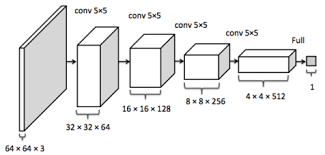

&nbsp;&nbsp;&nbsp;This time around we have an input image of <b>(64, 64, 3)</b>, same as <b>G</b>'s output. We pass it to <b>4 standard downsampling Conv layers</b>, again with a stride of <b>2</b>. In the final output layer, the image gets flattened to a vector, which is usually fed to a sigmoid function, which then outputs <b>D</b>'s prediction for that image <b>(a single value representing the probability in the range [0,1] - dog = 1 or no dog = 0)</b>.

&nbsp;&nbsp;&nbsp;Well, now you saw the basic idea behind <b>GANs</b> and <b>DCGANs</b>, so now we can proceed to generate some dogs :).

&nbsp;&nbsp;&nbsp;Let's first import some libraries and enable <b>Tensorflow's eager execution</b> by removing the computation graphs to speed up the computations.

## Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, zipfile
import os
import glob
import math
import random
import time
import datetime
import shutil
import imageio
from tqdm import tqdm, tqdm_notebook

from dataclasses import dataclass
from pathlib import Path
import warnings
from scipy import linalg

import xml.etree.ElementTree as ET 

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.contrib.eager.python import tfe

#from IPython import display

# libraries for SpectralNorm
from tensorflow.keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils

Using TensorFlow backend.


In [0]:
tf.enable_eager_execution()

Let's also set some input paths and default variables for later.

### Google Colab dataset loading

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp "drive/My Drive/Colab Notebooks/kaggle/kaggle.json" ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c generative-dog-images
!unzip 'Annotation.zip'
!unzip 'all-dogs.zip'
# if previous checkpoints exist, load them, comment for first run
!cp -rf "/content/drive/My Drive/Colab Notebooks/DCGAN Dog Generator/training_checkpoints/" ./training_checkpoints/

Output hidden; open in https://colab.research.google.com to view.

## Setting input variables

In [0]:
image_width = 64
image_height = 64
image_channels = 3
image_sample_size = 10000
image_output_dir = './output_images/'
image_input_dir = './all-dogs/'
image_ann_dir = "./Annotation/"
OUT_DIR = Path(image_output_dir)
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/kaggle/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'
TRAIN_DIR = Path(image_input_dir)

## Image preprocessing and EDA

&nbsp;&nbsp;&nbsp;Before we proceed with creating the <b>GAN</b> model let's first do a quick exploration of the <b>Stanford Dogs</b> dataset, which we'll be using. Because we also have the annotations for each image, we can use them to map each dog image to its respective breed. To do that, we can first make a dictionary that maps the breed code in the file name to the actual breed name.

### Creating the image features

In [0]:
dog_breed_dict = {}
for annotation in os.listdir(image_ann_dir):
    annotations = annotation.split('-')
    dog_breed_dict[annotations[0]] = annotations[1]

Here I'm going to use <b>OpenCV</b> for a quick function to read and transform the images to <b>RGB</b>.

In [0]:
def read_image(src):
    img = cv2.imread(src)
    if img is None:
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

### Crop the images and apply scaling

&nbsp;&nbsp;&nbsp;If we look at the dataset, we can see that each annotation folder contains a list of <b>xml</b> files. These files are associated with a specific image and contain very useful information, mainly the bounding boxes around each dog in the image. There are also images with more than one dog in them and this allows us to accurately crop them and make a dataset that contains <b>single dogs only</b> images.

&nbsp;&nbsp;&nbsp;Here we can utilize the <b>xml</b> library to create a tree and find the relevant elements for that annotation. For each object we can extract the bounding box coordinates, crop the images and normalize the crop by <b>shrinking</b> or <b>expanding</b> it depending on the result <b>image width</b>. Finally, we'll save the images in a numpy array.

In [0]:
def load_cropped_images(dog_breed_dict=dog_breed_dict, image_ann_dir=image_ann_dir, sample_size=25000, 
                        image_width=image_width, image_height=image_height, image_channels=image_channels):
    curIdx = 0
    breeds = []
    dog_images_np = np.zeros((sample_size,image_width,image_height,image_channels))
    for breed_folder in os.listdir(image_ann_dir):
        for dog_ann in tqdm(os.listdir(image_ann_dir + breed_folder)):
            try:
                img = read_image(os.path.join(image_input_dir, dog_ann + '.jpg'))
            except FileNotFoundError:
                continue
                
            tree = ET.parse(os.path.join(image_ann_dir + breed_folder, dog_ann))
            root = tree.getroot()
            
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                
                xmin = max(0, xmin - 4)        # 4 : margin
                xmax = min(width, xmax + 4)
                ymin = max(0, ymin - 4)
                ymax = min(height, ymax + 4)

                w = np.min((xmax - xmin, ymax - ymin))
                w = min(w, width, height)                     # available w

                if w > xmax - xmin:
                    xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
                    xmax = xmin + w
                if w > ymax - ymin:
                    ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
                    ymax = ymin + w
                
                img_cropped = img[ymin:ymin+w, xmin:xmin+w, :]      # [h,w,c]
                # Interpolation method
                if xmax - xmin > image_width:
                    interpolation = cv2.INTER_AREA          # shrink
                else:
                    interpolation = cv2.INTER_CUBIC         # expansion
                    
                img_cropped = cv2.resize(img_cropped, (image_width, image_height), 
                                         interpolation=interpolation)  # resize
                    
                dog_images_np[curIdx,:,:,:] = np.asarray(img_cropped)
                dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]]
                breeds.append(dog_breed_name)
                curIdx += 1
                
    return dog_images_np, breeds

*The features take about 2-3 mins to load. *

&nbsp;&nbsp;&nbsp;By trial, we can figure out that the result images with single dogs only are <b>22125</b> and thus we can specify the exact size of our numpy array. There are <b>120</b> different dog breeds.

In [14]:
start_time = time.time()
dog_images_np, breeds = load_cropped_images(sample_size=22125)
est_time = round(time.time() - start_time)
print("Feature loading time: {}.".format(str(datetime.timedelta(seconds=est_time))))

100%|██████████| 169/169 [00:00<00:00, 270.67it/s]

Feature loading time: 0:01:18.


In [16]:
print('Loaded features shape: ', dog_images_np.shape)
print('Loaded labels: ', len(breeds))

Loaded features shape:  (22125, 64, 64, 3)
Loaded labels:  22125


&nbsp;&nbsp;&nbsp;Now that we have the features and labels, we can plot them in a square grid to see what the crops look like and to make sure that they are labeled correctly.

In [0]:
def plot_features(features, labels, image_width=image_width, image_height=image_height, 
                image_channels=image_channels,
                examples=25, disp_labels=True): 
  
    if not math.sqrt(examples).is_integer():
        print('Please select a valid number of examples.')
        return
    
    imgs = []
    classes = []
    for i in range(examples):
        rnd_idx = np.random.randint(0, len(labels))
        imgs.append(features[rnd_idx, :, :, :])
        classes.append(labels[rnd_idx])
    
    
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)),figsize=(15,15),
    subplot_kw = {'xticks':[], 'yticks':[]},
    gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    for i, ax in enumerate(axes.flat):
        if disp_labels == True:
            ax.title.set_text(classes[i])
        ax.imshow(imgs[i])

Note that we need to normalize the pixel values to make sure that the dogs are plotted correctly.

Plotting cropped images by their specified coordinates..


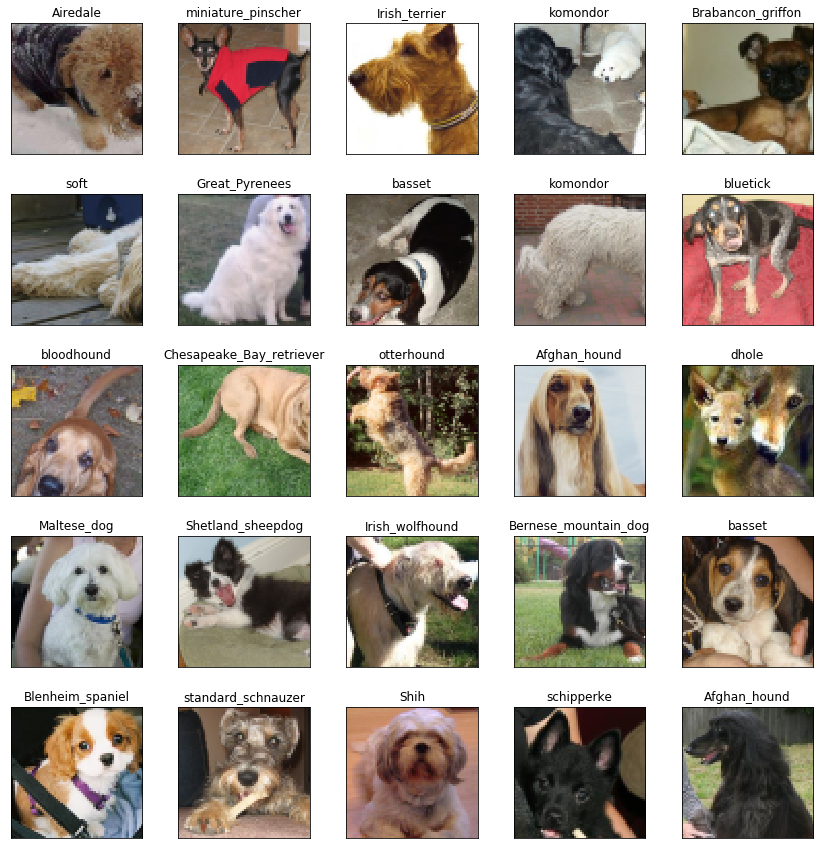

In [18]:
print('Plotting cropped images by their specified coordinates..')
plot_features(dog_images_np / 255., breeds, examples=25, disp_labels=True)

The crops definitely are not perfect, but they do seem to capture only one dog in each image.

### Normalize the pixel values of the images

&nbsp;&nbsp;&nbsp;If you recall from the <b>DCGAN</b> guideline, the <b>Generator</b> is suggested to have a <b>Tanh</b> activation function for its output layer. This means that it produces values in the range <b>[-1, 1]</b> meaning that we also have to apply the same range to our features as a preprocessing step.

In [0]:
dog_images_np = (dog_images_np - 127.5) / 127.5  # normalize the pixel range to [-1, 1] ((image - 127.5) / 127.5) or [0, 1] (image / 255.) alternatively

This is what the images would look like in the input layer of <b>D</b>.

Plotting cropped images by their specified coordinates..


W0829 08:31:33.245865 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0829 08:31:33.249140 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0829 08:31:33.252745 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0829 08:31:33.255767 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0829 08:31:33.258898 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0829 08:31:33.262245 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0829 08:31:33.265252 140419

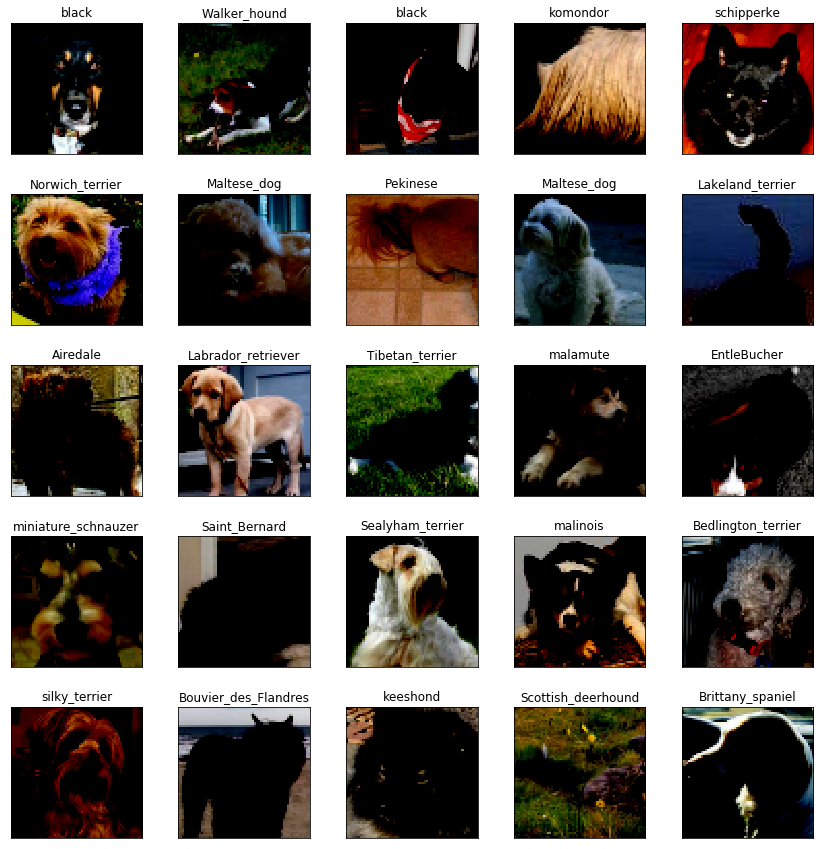

In [20]:
print('Plotting cropped images by their specified coordinates..')
plot_features(dog_images_np, breeds, examples=25, disp_labels=True)

If we select a random image and print out the <b>max and min</b> we can see that the values are correct.

In [21]:
print(np.max(dog_images_np[3,:,:,:]), np.min(dog_images_np[3,:,:,:]))

0.7254901960784313 -0.9921568627450981


### Deprocessing back to the original values

What if we want to return them back to normal? Easy, we just apply the reverse operations and plot them again.

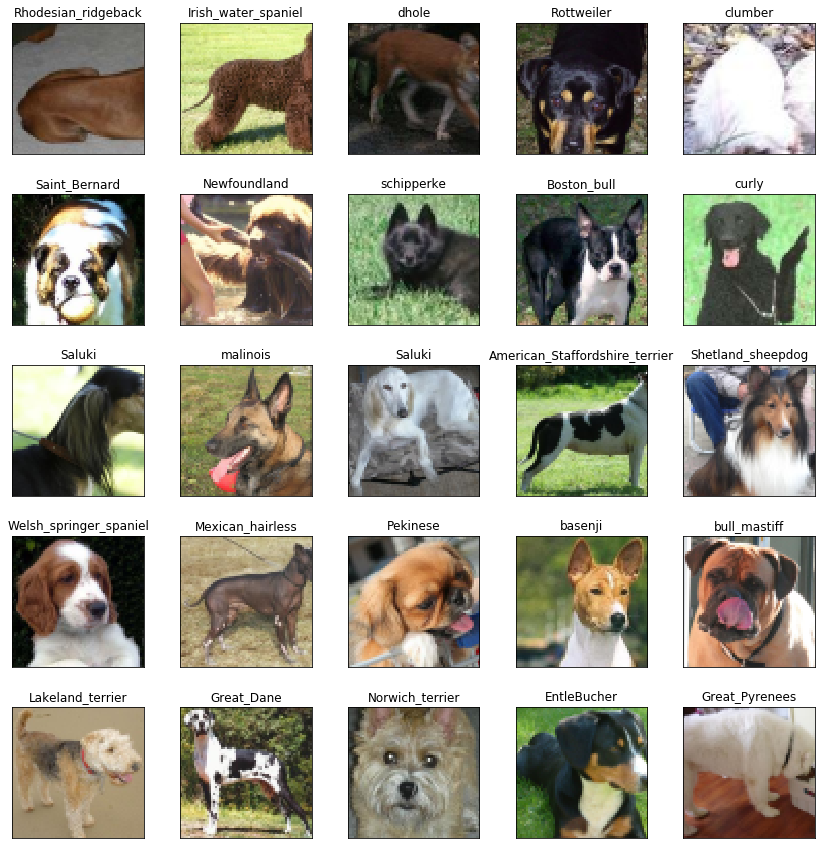

In [22]:
plot_features((dog_images_np * 127.5 + 127.5) / 255., breeds, examples=25, disp_labels=True)

## Creating the image dataset

&nbsp;&nbsp;&nbsp;Now let's use our numpy array of features to construct a <b>Tensorflow</b> dataset object. First, we can convert the data types to <b>float32</b>, which always helps to preserve some memory.

In [23]:
print("Dog features shape:", dog_images_np.shape)

Dog features shape: (22125, 64, 64, 3)


In [0]:
dog_features_tf = tf.cast(dog_images_np, 'float32')

### Data Augmentation

&nbsp;&nbsp;&nbsp;We could also apply <b>Data Augmentation</b> to our dataset. This includes random <b>horizontal flips</b>, zooming and cropping the image in random regions. Out of these, I found only the first method to be somewhat useful for adding some more variance to the dataset, as the other methods introduce a lot of noise.

&nbsp;&nbsp;&nbsp;So in this case, there will be a <b>50%</b> chance that an image in our dataset will be flipped from left to right.

In [0]:
def flip(x: tf.Tensor) -> (tf.Tensor):
    x = tf.image.random_flip_left_right(x)
    return x

def zoom(x: tf.Tensor) -> (tf.Tensor):
    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.7, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(64, 64))
        # Return a random crop
        return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return (tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x)))

### Set model hyperparameters

&nbsp;&nbsp;&nbsp;Here we have a whole list of hyperparameters that you can tune and play around with to try and improve the model. I've mostly gathered these values from research papers and experimented a bit with tweaking them and this is what I ended up with. Here's a list of things you could try out:

- <b>Sample size</b> - the number of features
- <b>Batch size</b> - 64 or 32 could improve performance, but are computationally heavy and you can only run the model for a small amount of epochs
- <b>Weight Init Std and Mean</b> - these values are come from research papers and seem to stabilize model training
- <b>Leaky ReLU slope</b> - the threshold for <b>D</b>'s activations, also seems robust
- <b>Downsize factor and Scale factor</b> - set up so that <b>G</b>'s noise vector can be reshaped to (4, 4, 512), other combinations might also work
- <b>Dropout</b> - amount of dropout layers, their placement and their rate could improve performance.
- <b>Learning rate and Learning rate decay</b> - very important to model convergence, hard to tune precisely, <b>G</b> and <b>D</b> can have different learning rates.
- <b>Noise vector shape</b> - usually 128 or 100 seems to be sufficient

In [0]:
sample_size = 22125
batch_size = 128
weight_init_std = 0.02
weight_init_mean = 0.0
leaky_relu_slope = 0.2
downsize_factor = 2
dropout_rate = 0.5
scale_factor = 4 ** downsize_factor
lr_initial_d = tfe.Variable(0.0002)
lr_initial_g = tfe.Variable(0.0002)
lr_decay_steps = 1000
noise_dim = 128

### Create tensorflow-type dataset

&nbsp;&nbsp;&nbsp;Now we can use <b>Tensorflow</b> to create the dataset by shuffling it, applying some augmentation, and finally separating it into batches of the specified <b>Batch size</b>.

In [0]:
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(sample_size).map(flip).batch(batch_size, drop_remainder=True)

In [28]:
print(dog_features_data)

<DatasetV1Adapter shapes: (128, 64, 64, 3), types: tf.float32>


## Normalization techniques

### Weight Initialization

&nbsp;&nbsp;&nbsp;Before we actually make the <b>Generator</b>, let's see a few normalizations that can gradually speed up a <b>DCGAN</b>'s convergence. 

&nbsp;&nbsp;&nbsp;One of these methods is <b>Weight initialization</b>. It turns out that it's pretty important for training stable <b>GANs</b>. Firstly, the model weights need to be <b>zero-centered</b> with a slight increase of <b>std</b>(0.02). This stabilizes both <b>D</b> and <b>G</b> during training and prevents the model gradients from vanishing or exploding. This is a key step in every case, where we have to use random variables in our model (the random noise vector). 

&nbsp;&nbsp;&nbsp;Here is an example of how <b>Weight initialization</b> can seriously affect the learning process of a Neural Network.

![Weight Initialization example](https://intoli.com/blog/neural-network-initialization/img/training-losses.png)

&nbsp;&nbsp;&nbsp;We can also apply a <b>Truncated Normal</b> distribution using <b>Keras</b>, which will discard <b>values more than 2 standard deviations from the mean</b>. This could perhaps eliminate some outlier points during training.

In [0]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean,
                                                          seed=42)

### Spectral Normalization

&nbsp;&nbsp;&nbsp;<b>Spectral Normalization</b> is a new type of weight initialization, designed specifically for <b>GANs</b>, which seems to further stabilize model training (you can read more from this [paper](https://arxiv.org/pdf/1802.05957.pdf)). For a more detailed explanation on <b>Spectral Normalization</b> and why it works it also worth to check out this [post](https://christiancosgrove.com/blog/2018/01/04/spectral-normalization-explained.html), it has very intuitive examples.

&nbsp;&nbsp;&nbsp;<b>Spectral Normalization</b> of a single weight in our network can be defined as the following:

$$ \sigma(W) = ||Wv|| = u^{T}Wv $$
$$ W_{SN}(W) = \frac{W}{\sigma(W)} $$

&nbsp;&nbsp;&nbsp;Here $u$ and $v$ are simple random vectors of the same size. They are utilized to perform what's called a <b>power iteration</b> operation on the specific weight, for each learning step and it proves to be a lot more computationally efficient than simply penalizing the gradients.

&nbsp;&nbsp;&nbsp;Afterwards, in the backpropagation step, we use $W_{SN}(W)$ to update the weights instead of $W$.

&nbsp;&nbsp;&nbsp;For this project, I will reuse some custom <b>Keras</b> layers implemented by <b>IShengFang</b> ([official code](https://github.com/IShengFang/SpectralNormalizationKeras)), to apply <b>Spectral Normalization</b> on top of <b>Conv</b> and <b>Dense</b> layers.

&nbsp;&nbsp;&nbsp;Here is also a good example on the effect of <b>Spectral Normalization</b>:

<center><b>With SN</b></center>
![SNGAN](https://raw.githubusercontent.com/IShengFang/SpectralNormalizationKeras/master/img/generated_img_CIFAR10_resnet_SN_GP/loss.png)

<center><b>Without SN</b></center>
![StandardGAN](https://raw.githubusercontent.com/IShengFang/SpectralNormalizationKeras/master/img/generated_img_CIFAR10_resnet_noSN_GP/loss.png)

In [0]:
class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h)
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)
            
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

&nbsp;&nbsp;&nbsp;Let's also define some template layers in <b>Keras</b>, so that we can create <b>G</b> and <b>D</b> more easily later on. The standard pattern for the layers will be:

<center><b>TP_Conv_Block = [(Conv(SN)2DTranspose (upsample)) -> (BatchNorm) -> (ReLU)]</b></center>

<center><b>Conv_Block = [(Conv(SN)2D (downsample)) -> (BatchNorm) -> (LeakyReLU)]</b></center>

In [0]:
def transposed_conv(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (ksize, ksize),
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def transposed_convSN(model, out_channels, ksize, stride_size, ptype='same'):
    model.add(ConvSN2DTranspose(out_channels, (ksize, ksize), 
                              strides=(stride_size, stride_size), padding=ptype, 
                              kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

def convSN(model, out_channels, ksize, stride_size):
    model.add(ConvSN2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same',
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    #model.add(Dropout(dropout_rate))
    return model

## The Generator

&nbsp;&nbsp;&nbsp;We can finally define our generator. The model structure is mostly based on the official DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) with a few tweaks that I found beneficial to the performance. Here is the overall structure:

<center><b>[Input(128, 1) -> Dense(2048,) -> Reshape(4, 4, 128) -> TP_Conv_Block(Depth=512, K=5x5, S=1x1) -> Dropout(0.5) -> TP_Conv_Block(Depth=256, K=5x5, S=2x2) -> Dropout(0.5) -> TP_Conv_Block(Depth=128, K=5x5, S=2x2) -> TP_Conv_Block(Depth=64, K=5x5, S=2x2) -> TP_Conv_Block(Depth=32, K=5x5, S=2x2) -> Dense(Depth=3, Tanh)]</b></center>

In [0]:
def DogGenerator():
    model = Sequential()
    model.add(Dense(image_width // scale_factor * image_height // scale_factor * 128,
                    input_shape=(noise_dim,), kernel_initializer=weight_initializer))
    #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
    #model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Reshape((image_height // scale_factor, image_width // scale_factor, 128)))
    
    model = transposed_conv(model, 512, ksize=5, stride_size=1)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 256, ksize=5, stride_size=2)
    model.add(Dropout(dropout_rate))
    model = transposed_conv(model, 128, ksize=5, stride_size=2)
    model = transposed_conv(model, 64, ksize=5, stride_size=2)
    model = transposed_conv(model, 32, ksize=5, stride_size=2)
    
    model.add(Dense(3, activation='tanh', kernel_initializer=weight_initializer))

    return model

In [34]:
dog_generator = DogGenerator()
print(dog_generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3

&nbsp;&nbsp;&nbsp;We can confirm that the <b>Generator</b> works initially by feeding it a random noise vector of the right size. The output image should be normalized to similar black-colored pixels due to the <b>Weight Initialization</b> step described earlier <b>(they should be relatively zero-centered)</b>.

W0829 08:32:53.506269 140419294877568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)
(1, 128) 0.014456073 1.1784573


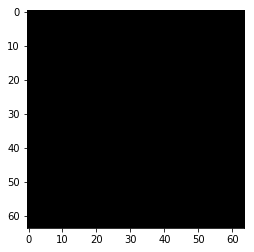

In [35]:
# random noise vector
noise = tf.random.normal([1,noise_dim])
#sample = generate_latent_points(100, 50)
# run the generator model with the noise vector as input
generated_image = dog_generator(noise, training=False)
# display output
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)
#print(sample.shape, sample.mean(), sample.std())
print(noise.shape, tf.math.reduce_mean(noise).numpy(), tf.math.reduce_std(noise).numpy())

## The Discriminator

&nbsp;&nbsp;&nbsp;The <b>Discriminator</b> is relatively easier to implement, since its basically a small <b>CNN</b> two-class classifier. We can choose whether to apply <b>Spectral Normalization</b> or not and see the performance effects. For this example, I will try to apply <b>SN</b> only in <b>D</b>. Here is <b>D</b>'s structure:

<center><b>[Input(128, 128, 3) -> Conv(SN)2D(Depth=64, K=5x5, S=1x1, same) -> LeakyReLU -> Conv_Block(Depth=64, K=5x5, S=2x2) -> Conv_Block(Depth=128, K=5x5, S=2x2) -> Conv_Block(Depth=256, K=5x5, S=2x2) -> Flatten -> Dense(16384, Sigmoid)]</b></center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;Also note that all <b>Conv</b> and <b>Dense</b> layers are initialized with the <b>Truncated Normal</b> distribution defined above. Another thing is that the <b>bias</b> term is removed from the <b>Conv</b> layers, which also stabilizes the model a little bit.

In [0]:
def DogDiscriminator(spectral_normalization=True):
    model = Sequential()
    if spectral_normalization:
        model.add(ConvSN2D(64, (5, 5), strides=(1,1), padding='same', use_bias=False,
                         input_shape=[image_height, image_width, image_channels], 
                         kernel_initializer=weight_initializer))
        #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        #model.add(Dropout(dropout_rate))
        
        model = convSN(model, 64, ksize=5, stride_size=2)
        #model = convSN(model, 128, ksize=3, stride_size=1)
        model = convSN(model, 128, ksize=5, stride_size=2)
        #model = convSN(model, 256, ksize=3, stride_size=1)
        model = convSN(model, 256, ksize=5, stride_size=2)
        #model = convSN(model, 512, ksize=3, stride_size=1)
        #model.add(Dropout(dropout_rate))

        model.add(Flatten())
        model.add(DenseSN(1, activation='sigmoid'))
    else:
        model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False,
                         input_shape=[image_height, image_width, image_channels], 
                         kernel_initializer=weight_initializer))
        #model.add(BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MOMENTUM))
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        #model.add(Dropout(dropout_rate))

        model = conv(model, 64, ksize=4, stride_size=2)
        #model = convSN(model, 128, ksize=3, stride_size=1)
        model = conv(model, 128, ksize=4, stride_size=2)
        #model = convSN(model, 256, ksize=3, stride_size=1)
        model = conv(model, 256, ksize=4, stride_size=2)
        #model = convSN(model, 512, ksize=3, stride_size=1)

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
    return model

In [37]:
dog_discriminator = DogDiscriminator(spectral_normalization=True)
print(dog_discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_s_n2d (ConvSN2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv_s_n2d_1 (ConvSN2D)      (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv_s_n2d_2 (ConvSN2D)      (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)      

Below we can observe, that <b>D</b> indeed outputs a probability very close to <b>0.5</b> for a noisy input.

In [38]:
decision = dog_discriminator(generated_image)
print(decision)

tf.Tensor([[0.50001353]], shape=(1, 1), dtype=float32)


## Further optimization tricks

### Label smoothing

&nbsp;&nbsp;&nbsp;One regularization method that can be applied during training is called <b>Label smoothing</b>. What this does is that it essentially prevents <b>D</b> from being overconfident or underconfident in its predictions. If <b>D</b> becomes too certain that there is a dog in a specific image, <b>G</b> can exploit that fact and continuously start to generate only images of that sort and in turn, cease to improve. We can combat this, by setting the class labels to be in the range <b>[0, 0.3]</b> for the negative classes and <b>[0.7, 1]</b> for the positive ones. 

&nbsp;&nbsp;&nbsp;This will prevent the overall probabilities from getting very close to the two thresholds.

In [0]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

### Introducing some noise to the labels

&nbsp;&nbsp;&nbsp;This technique is also called <b>Instance Noise</b>. By adding a small amount of error to the labels (let's say 5%), this tends to make the true and predicted distributions more spread out and thus start to overlap with each other. This in turn makes fitting a custom distribution of generated images easier in the learning process.

&nbsp;&nbsp;&nbsp;Here is a good example of how the two distributions look like with these techniques:

![Smoothing and noise effect on distributions](https://www.inference.vc/content/images/2016/10/instance_noise.png)

In [0]:
# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1, y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

### Optimizers

&nbsp;&nbsp;&nbsp;The best proven optimization algorithm for this task is <b>Adam</b> with a standard learning rate of <b>0.0002</b> for both models and a beta of <b>0.5</b>.

In [0]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate=lr_initial_g, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=lr_initial_d, beta1=0.5)
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

### Defining the loss functions

&nbsp;&nbsp;&nbsp;Another new trend in optimizing <b>GANs</b> recently has been applying a <b>Relativistic</b> loss function as opposed to the standard one. Those functions measure the probability that the real data is more "realistic" than the generated data. One of the more popular relativistic function choices include <b>RaLSGAN (Relativistic Average Least Squares), RaSGAN (Relativistic Average Standard) and RaHinge (Relativistic Hinge loss)</b>.

&nbsp;&nbsp;&nbsp;But before all of that, let's define the standard <b>GAN</b> loss:

$$ \underset{D}{min}(V(D)) = - E_{x}[\log{D(x)}] - E_{z}[\log{(1-D(G(z)))}] $$

&nbsp;&nbsp;&nbsp;As we can observe, this is basically the standard <b>Binary Crossentropy loss</b> used for classification tasks or the <b>Logistic Loss</b> between the real and generated distributions.

&nbsp;&nbsp;&nbsp;In comparison, here is what an <b>RSGAN (Relativistic Standard)</b> loss looks like:

$$ L^{RSGAN}_{D} = - E_{(x_{r},x_{f})}[\log{(sigmoid(C(x_{r}) - C(x_{f})))}] $$
$$ L^{RSGAN}_{G} = - E_{(x_{r},x_{f})}[\log{(sigmoid(C(x_{f}) - C(x_{r})))}] $$

&nbsp;&nbsp;&nbsp;In this case the task is different, to measure the similarity between the <b>real (r)</b> and <b>fake (f)</b> data distributions. RSGAN reaches the optimal point when D(x) = 0.5 (i.e. $C(x_{r}) = C(x_{f})$). There are many relativistic loss function variants and they all contain different methods for measuring this similarity. In this project, I've tried out <b>3</b> of the variants that seemed to have the best documented <b>MIFID</b> score <b>(RaLSGAN, RaSGAN and RaHinge)</b>. Feel free to try out different losses for yourself to see if you can improve the performance ;). Here's a big list of the most commonly used ones:

![GAN losses](https://miro.medium.com/max/875/1*QKG1fVOMjGlVUvICYmz8vQ.png)

&nbsp;&nbsp;&nbsp;With this in mind, I have devised a nice little decision tree function for choosing the losses for both <b>G</b> and <b>D</b>. Note that <b>instance noise</b> and <b>label smoothing</b> need to be applied before calculating the actual losses. 

&nbsp;&nbsp;&nbsp;Throughout many trials for this particular problem, I didn't find any increase in performance by switching to <b>Relativistic</b> losses, so I decided to stick with the standard <b>GAN</b> loss function, as it is much simpler to estimate, though in some cases these losses can really speed up convergence in your model.

In [0]:
def discriminator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True, label_noise=True):
    if label_noise and apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
        real_output_smooth = smooth_positive_labels(real_output_noise)
        fake_output_smooth = smooth_negative_labels(fake_output_noise)
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output_smooth - tf.reduce_mean(fake_output_smooth) - tf.ones_like(real_output_smooth)))
        + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output_smooth) + tf.ones_like(fake_output_smooth)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_smooth)
                avg_real_logit = tf.reduce_mean(real_output_smooth)
                D_r_tilde = tf.nn.sigmoid(real_output_smooth - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output_smooth) - (real_output_smooth - tf.reduce_mean(fake_output_smooth))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) + (fake_output_smooth - tf.reduce_mean(real_output_smooth))))
        total_loss = real_loss + fake_loss
        return total_loss
    elif label_noise and not apply_label_smoothing:
        real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
        fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_noise), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_noise), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output_noise - tf.reduce_mean(fake_output_noise) - tf.ones_like(real_output_noise)))
        + tf.reduce_mean(tf.square(fake_output_noise - tf.reduce_mean(real_output_noise) + tf.ones_like(fake_output_noise)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_noise)
                avg_real_logit = tf.reduce_mean(real_output_noise)
                D_r_tilde = tf.nn.sigmoid(real_output_noise - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_noise - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output_noise) - (real_output_noise - tf.reduce_mean(fake_output_noise))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_noise) + (fake_output_noise - tf.reduce_mean(real_output_noise))))
        total_loss = real_loss + fake_loss
        return total_loss
    elif apply_label_smoothing and not label_noise:
        real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
        fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output_smooth - tf.reduce_mean(fake_output_smooth) - tf.ones_like(real_output_smooth)))
        + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output_smooth) + tf.ones_like(fake_output_smooth)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_smooth)
                avg_real_logit = tf.reduce_mean(real_output_smooth)
                D_r_tilde = tf.nn.sigmoid(real_output_smooth - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output_smooth) - (real_output_smooth - tf.reduce_mean(fake_output_smooth))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) + (fake_output_smooth - tf.reduce_mean(real_output_smooth))))
        total_loss = real_loss + fake_loss
        return total_loss    
    else:
        if loss_func == 'gan': 
            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output) - tf.ones_like(real_output)))
        + tf.reduce_mean(tf.square(fake_output - tf.reduce_mean(real_output) + tf.ones_like(fake_output)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output)
                avg_real_logit = tf.reduce_mean(real_output)
                D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_r_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_f_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) - (real_output - tf.reduce_mean(fake_output))))
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) + (fake_output - tf.reduce_mean(real_output))))
        total_loss = real_loss + fake_loss
        return total_loss

In [0]:
def generator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True):
    if apply_label_smoothing:
        fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
        if loss_func == 'gan':
            return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output_smooth) + tf.ones_like(real_output)))
        + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output) - tf.ones_like(fake_output_smooth)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output_smooth)
                avg_real_logit = tf.reduce_mean(real_output)
                D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_f_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_r_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) - (fake_output_smooth - tf.reduce_mean(real_output))))
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.reduce_mean(fake_output_smooth))))
                loss = fake_loss + real_loss
                return loss
    else:           
        if loss_func == 'gan':
            return cross_entropy(tf.ones_like(fake_output), fake_output)
        else:
            if loss_func == 'ralsgan':
                return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output) + tf.ones_like(real_output)))
        + tf.reduce_mean(tf.square(fake_output - tf.reduce_mean(real_output) - tf.ones_like(fake_output)))) / 2.
            elif loss_func == 'rasgan':
                avg_fake_logit = tf.reduce_mean(fake_output)
                avg_real_logit = tf.reduce_mean(real_output)
                D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
                D_f_tilde = tf.nn.sigmoid(fake_output - avg_real_logit)
                total_loss = - tf.reduce_mean(tf.log(
                    D_f_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_r_tilde + 1e-14))
                return total_loss
            elif loss_func == 'rahinge':
                fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) - (fake_output - tf.reduce_mean(real_output))))
                real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.reduce_mean(fake_output))))
                loss = fake_loss + real_loss
                return loss 

### Define a checkpointer

&nbsp;&nbsp;&nbsp;Let's finally add a checkpointer to be able to save and reuse our model.

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=dog_generator,
                                 discriminator=dog_discriminator)

### Main training loop

&nbsp;&nbsp;&nbsp;Let's also fix the number of epochs for training and the number of images to feed to the <b>Generator</b> for visualizing results during that training.

In [0]:
EPOCHS = 300
num_examples_to_generate = 64
seed = tf.random.normal([num_examples_to_generate, noise_dim])

&nbsp;&nbsp;&nbsp;One training step of a <b>DCGAN</b> consists of three standard steps:

1. <b>Forward prop</b> - <b>G</b> creates a batch of fake images; this, alongside a batch of real images is fed to <b>D</b>.
2. <b>Calculate both G and D's loss function</b>.
3. <b>Backprop</b> - compute gradients for <b>G</b> and <b>D</b> optimize the weights.

In [0]:
def train_step(images, loss_type='gan'):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = dog_generator(noise, training=True)
        
        real_output = dog_discriminator(images, training=True)
        fake_output = dog_discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(real_output, fake_output, loss_type, apply_label_smoothing=True)
        disc_loss = discriminator_loss(real_output, fake_output, loss_type, 
                                       apply_label_smoothing=True, label_noise=True)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, dog_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dog_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, dog_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dog_discriminator.trainable_variables))
    
    return gen_loss, disc_loss

&nbsp;&nbsp;&nbsp;Let's also define some functions to visualize the model losses by epoch and as a whole.

In [0]:
def plot_losses(G_losses, D_losses, all_gl, all_dl, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(all_gl)),all_gl,label='G')
    plt.plot(np.arange(len(all_dl)),all_dl,label='D')
    plt.legend()
    #plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
    plt.title('All Time Loss')
    plt.show()

&nbsp;&nbsp;&nbsp;We can also use the following function to plot a grid of the generated images.

In [0]:
def generate_and_save_images(model, epoch, test_input, rows, cols):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(14,14))
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

&nbsp;&nbsp;&nbsp;To generate a single test image, we can also reuse the same method.

In [0]:
def generate_test_image(model, noise_dim=noise_dim):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :] * 127.5 + 127.5) / 255.)
    plt.axis('off') 
    plt.show()

## Evaluating GANs - FID and MIFID

### Inception Score

&nbsp;&nbsp;&nbsp;We still haven't mentioned how a <b>GAN</b> is usually evaluated. Most research papers that use benchmarks to estimate how well a <b>GAN</b> performs are usually based on what's called the <b>Inception Score</b>. This measures two main characteristics of the input images:

- <b>The variety (for example generating different types of dog breeds)</b>
- <b>The distinction (or quality of the image)</b>

&nbsp;&nbsp;&nbsp;If both things are true, the score will be high. If either or both are false, the score will be low.
A higher score is better. It means your GAN can generate many different distinct images. The lowest score possible is zero. Mathematically the highest possible score is infinity, although in practice there will probably emerge a non-infinite ceiling.

&nbsp;&nbsp;&nbsp;The <b>Inception Score</b> is derived from Google's [Inception Network](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202), which is one of the state-of-the-art deep architectures for classifying images. By passing the images from our GAN through the classifier, we can measure properties of our generated images. To produce the score, we need to calculate the similarity/distance between the real and fake distributions of images. This is done using the <b>KL(Kullback–Leibler) divergence formula</b>: 

$$ D_{KL}(P \:||\:Q) = - \sum_{x \in X}P(x)\log{\frac{Q(x)}{P(x)}} $$

&nbsp;&nbsp;&nbsp;Here, <b>P and Q</b> are the two measured distributions. In this case, <b>higher KL divergence</b> means better results - the quality of the images is similar and there is a wide variety of labels present. In the opposite case, the <b>low KL divergence</b> can be due to either low quality or low variety of labels:

![KL divergence](https://miro.medium.com/max/2170/1*hPEJY3MkOZyKFA6yEqzuyg.png)

### FID (Frechet Inception Distance)

&nbsp;&nbsp;&nbsp;One shortcoming for <b>IS</b> is that it can misrepresent the performance if it only generates one image per class. To combat this we can use the <b>FID (Frechet Inception Distance)</b>. This measure defines the two previous types of images as multivariate <b>Gaussian distributions</b> with mean $\mu$ and covariance $\Sigma$ (Sigma). Let's see how this distance is calculated:

$$ FID(x,\:g) = \big\|\mu_{x} - \mu_{g}\big\|^2_2 + Tr(\Sigma_{x} + \Sigma_{g} - 2(\Sigma_{x}\Sigma_{g})^{\frac{1}{2}}) $$

&nbsp;&nbsp;&nbsp;Here, $x$ and $g$ represent the real and fake distribution of images, while $Tr$ is the sum of diagonal elements of the results.

> <b> Lower FID values mean better image quality and diversity. </b>

![FID in popular datasets](https://miro.medium.com/max/1848/1*8PzOnrzIeuM0E1unrFKLfg.png)

&nbsp;&nbsp;&nbsp;Here are also a few useful notes on why <b>FID</b> is a good measure:

> - <b>FID is more robust to noise than IS.</b>
> - <b>If the model only generates one image per class, the distance will be high. So FID is a better measurement for image diversity.</b>
> - <b>By computing the FID between a training dataset and a testing dataset, we should expect the FID to be zero since both are real images. (although there is usually a small amount of error)</b>
> - <b>FID and IS are based on feature extraction (the presence or the absence of features).</b>

### MIFID (Memorization Informed Frechet Inception Distance)

&nbsp;&nbsp;&nbsp;Here is Kaggle's official evaluation workflow for this competition:

![Kaggle workflow](https://i.imgur.com/Vl0AcWd.png)

&nbsp;&nbsp;&nbsp;As we can see, in addition to the <b>FID</b> metric, there is an additional <b>Memorization Score</b> added to the calculation. This is basically a <b>Cosine distance</b> formula that measures the similarity between the real and fake images. My guess is that this has been done to make sure that the images fed to the evaluation kernel have actually been generated by a <b>GAN</b> and not just replicated or modified from the real dataset.

&nbsp;&nbsp;&nbsp;Thankfully, the <b>MIFID</b> evaluator has been implemented by the Kaggle team [(here)](https://www.kaggle.com/wendykan/demo-mifid-metric-for-dog-image-generation-comp) and we don't have to worry about it. 
To use it, make sure you add this [dataset](https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input) to your input.

In [0]:
class KernelEvalException(Exception):
    pass


@dataclass
class MiFIDEvaluator(object):
    model_path: str
    train_images_path: str
    feature_path: str = None
    imsize: int = 64
    output_layer: str = 'Pretrained_Net/pool_3:0'
    input_layer: str = 'Pretrained_Net/ExpandDims:0'
    output_shape: int = 2048
    cosine_distance_eps: float = 0.1
    batch_size: int = 50
    fid_epsilon: float = 1e-14
    
    def __post_init__(self):
        tf.reset_default_graph()
        self.create_model_graph()
        with tf.Session() as sess:
            if self.feature_path is None:
                self.mu2, self.sigma2, self.features2 = self._handle_path_memorization(
                    self.train_images_path, sess, is_checksize=False, is_check_png=False)
            else:
                with np.load(self.feature_path) as f:
                    self.mu2, self.sigma2, self.features2 = f['m'], f['s'], f['features']
    
    def create_model_graph(self):
        with tf.gfile.FastGFile(self.model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='Pretrained_Net')
            
    def img_read_checks(self, filename, is_checksize=False, is_check_png=False):
        im = Image.open(str(filename))
        if is_checksize and im.size != (self.imsize, self.imsize):
            raise KernelEvalException(f'The images are not of size {check_imsize}')
        if is_check_png and im.format != 'PNG':
            raise KernelEvalException('Only PNG images should be submitted.')

        if self.imsize is None:
            return im
        else:
            return im.resize((self.imsize, self.imsize), Image.ANTIALIAS)
        
    def _get_model_layer(self, sess):
        layer = sess.graph.get_tensor_by_name(self.output_layer)
        ops = layer.graph.get_operations()
        for op_idx, op in enumerate(ops):
            for o in op.outputs:
                shape = o.get_shape()
                if shape._dims != []:
                    shape = [s.value for s in shape]
                    new_shape = []
                    for j, s in enumerate(shape):
                        if s == 1 and j == 0:
                            new_shape.append(None)
                        else:
                            new_shape.append(s)
                    o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
        return layer
        
    def get_activations(self, images, sess):
        inception_layer = self._get_model_layer(sess)
        n_images = images.shape[0]
        if self.batch_size > n_images:
            warnings.warn('batch size is bigger than the data size. setting batch size to data size')
            self.batch_size = n_images
        n_batches = n_images // self.batch_size + 1
        pred_arr = np.empty((n_images, self.output_shape))
        for i in range(n_batches):
            start = i * self.batch_size
            if start + self.batch_size < n_images:
                end = start + self.batch_size
            else:
                end = n_images

            batch = images[start:end]
            pred = sess.run(inception_layer, {self.input_layer: batch})
            pred_arr[start:end] = pred.reshape(-1, self.output_shape)
        return pred_arr
        
    def calculate_activation_statistics(self, images, sess):
        act = self.get_activations(images, sess)
        mu = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return mu, sigma, act
            
    def _handle_path_memorization(self, path, sess, is_checksize, is_check_png):
        path = Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))

        # In production we don't resize input images. This is just for demo purpose. 
        x = np.array([np.array(self.img_read_checks(fn, is_checksize, is_check_png)) for fn in files])
        m, s, features = self.calculate_activation_statistics(x, sess)
        del x
        return m, s, features
    
    def calculate_frechet_distance(self, mu1, sigma1):
        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(self.mu2)
        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(self.sigma2)

        assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
        assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

        # product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = f'fid calculation produces singular product; adding {self.eps} to diagonal of cov estimates'
            warnings.warn(msg)
            offset = np.eye(sigma1.shape[0]) * self.eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
            
        # numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError(f'Imaginary component {m}')
            covmean = covmean.real
        tr_covmean = np.trace(covmean)
        return (mu1 - mu2).dot(mu1 - mu2) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    
    @staticmethod
    def normalize_rows(x):
        return np.nan_to_num(x / np.linalg.norm(x, ord=2, axis=1, keepdims=True))
    
    def cosine_distance(self, features1):
        features1_nozero = features1[np.sum(features1, axis=1) != 0]
        features2_nozero = self.features2[np.sum(self.features2, axis=1) != 0]
        norm_f1 = self.normalize_rows(features1_nozero)
        norm_f2 = self.normalize_rows(features2_nozero)

        d = 1.0 - np.abs(np.matmul(norm_f1, norm_f2.T))
        mean_min_d = np.mean(np.min(d, axis=1))
        return mean_min_d
            
    def calculate_kid_given_paths(self, user_images_unzipped_path):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            m1, s1, features1 = self._handle_path_memorization(
                user_images_unzipped_path, sess, is_checksize=True, is_check_png=True)

            fid_value = self.calculate_frechet_distance(m1, s1)
            distance = self.cosine_distance(features1)
            return fid_value, distance
        
    def distance_thresholding(self, d):
        if d < self.cosine_distance_eps:
            return d
        else:
            return 1
        
    def evaluate(self, user_images_unzipped_path):
        fid_value, distance = self.calculate_kid_given_paths(user_images_unzipped_path)
        distance = self.distance_thresholding(distance)
        return fid_value, distance, fid_value / (distance + self.fid_epsilon)

### Image zipping and saving functions

&nbsp;&nbsp;&nbsp;I'm just going to add two more for zipping the final <b>10K</b> images for submission and generating temporary images to calculate the <b>MIFID</b> in between certain epochs during training.

In [0]:
def zip_images(filename='images.zip'):
    # SAVE TO ZIP FILE NAMED IMAGES.ZIP
    z = zipfile.PyZipFile(filename, mode='w')
    for k in range(image_sample_size):
        generated_image = dog_generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        z.write(f)
        os.remove(f)
        #if k % 1000==0: print(k)
    z.close()
    print('Saved final images for submission.')
    
def save_images(directory=OUT_DIR):
    for k in range(image_sample_size):
        generated_image = dog_generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        f = os.path.join(directory, f)
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        #if k % 1000==0: print(k)
    print('Saved temporary images for evaluation.')

## Model training and avoiding Mode Collapse

&nbsp;&nbsp;&nbsp;It's finally time to implement the final training function that wraps up the whole process. There are also a few techniques used here that I haven't mentioned yet. Let's see what they are.

### Learning rate decay

&nbsp;&nbsp;&nbsp;This one is experimental and doesn't always help improve performance, but I don't think it would hurt either way. The idea here is to decrease the <b>learning rate</b> by a very small amount for each training step/steps, in order to stabilize the training process and speed up convergence (and escape from local minima). For this project, I am using the <b>[Cosine learning rate decay](https://www.tensorflow.org/api_docs/python/tf/train/cosine_decay)</b> in <b>Tensorflow</b> to reduce the learning rate for every ```decay_step``` iterations.

### Dealing with mode collapse

&nbsp;&nbsp;&nbsp;Other than <b>Non-convergence</b> and <b>Vanishing and Exploding gradients</b>, <b>GANs</b> sometimes suffer from another major problem called <b>Mode Collapse</b>. This happens when <b>G</b> starts to produce limited varieties of samples. Here is a good example of <b>Mode Collapse</b> for a <b>GAN</b> trained on the <b>MNIST</b> dataset where <b>G</b> continuously produces only images for a single class label:

![Mode collapse](https://miro.medium.com/max/2115/1*fNGcuJDskQTNoPR_1C12_g.png)

> Mode collapse is one of the hardest problems to solve in GANs. A complete collapse is not common but a partial collapse happens often. 

&nbsp;&nbsp;&nbsp;We've already seen some methods that can potentially eliminate <b>Mode Collapse</b> like <b>Label smoothing</b>, <b>Instance Noise</b>, <b>Weight Initialization</b> and so on. One other method that we could apply during training is called <b>Experience Replay</b>. 

&nbsp;&nbsp;&nbsp;<b>Experience Replay</b> preserves some of the recently generated images in memory. For every ```replay_step``` iterations, we train <b>D</b> on those previous images to "remind" the network of previous generations and thus decrease the chance of <b>overfitting</b> to a particular instance of data batches during training. In this example, I am using a slightly different form of <b>Experience Replay</b> in the sense that, I am generating a new extra image for each training step to store in a list, instead of feeding it actual generated images from previous iterations, since storing data during <b>Eager execution</b> isn't an easy task.

&nbsp;&nbsp;&nbsp;*EDIT: As Kaggle was running into memory issues after ~7-8 hours of runtime, I decided against using experience replay. Let me know if you find a workaround for this :D.*

&nbsp;&nbsp;&nbsp;Other than this the training process is fairly straight-forward. There are additional steps for displaying the intermediate results like the images, losses and calculating the <b>MIFID</b>. At the end of the learning process, we print out the final evaluation and a larger grid of the final images.

In [0]:
display_results = 40
calculate_mifid = 50
replay_step = 50
decay_step = 50


def train(dataset, epochs, retrain=False):
    all_gl = np.array([]); all_dl = np.array([])
    #best recorded mifid, or default 1000
    best_mifid_score = 1000
    #last checkpointed epoch, used if continuing a checkpointed model
    last_saved_epoch = 300
    exp_replay = []
    for epoch in tqdm(range(epochs)):
        
        G_loss = []; D_loss = []
        
        start = time.time()
        new_lr_d = lr_initial_d
        new_lr_g = lr_initial_g
        global_step = 0
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            global_step = global_step + 1
            G_loss.append(g_loss); D_loss.append(d_loss)
            all_gl = np.append(all_gl,np.array([G_loss]))
            all_dl = np.append(all_dl,np.array([D_loss]))
        
        # generate an extra image for each epoch and store it in memory for experience replay
        
        '''
        generated_image = dog_generator(tf.random.normal([1, noise_dim]), training=False)
        exp_replay.append(generated_image)
        if len(exp_replay) == replay_step:
            print('Executing experience replay..')
            replay_images = np.array([p[0] for p in exp_replay])
            dog_discriminator(replay_images, training=True)
            exp_replay = []    
        '''
         
        #display.clear_output(wait=True)
        if (epoch + 1) % display_results == 0 or epoch == 0:
            plot_losses(G_loss, D_loss, all_gl, all_dl, epoch + 1)
            if retrain:
              generate_and_save_images(dog_generator, cur_epoch + 1, seed, rows=8, cols=8)
            else:
              generate_and_save_images(dog_generator, epoch + 1, seed, rows=8, cols=8)
        
        if (epoch + 1) % calculate_mifid == 0:            
            OUT_DIR.mkdir(exist_ok=True)
            save_images(OUT_DIR)
            evaluator = MiFIDEvaluator(MODEL_PATH, TRAIN_DIR)
            fid_value, distance, mi_fid_score = evaluator.evaluate(OUT_DIR)
            print(f'FID: {fid_value:.5f}')
            print(f'distance: {distance:.5f}')
            print(f'MiFID: {mi_fid_score:.5f}')
            shutil.rmtree(OUT_DIR)
            print('Removed temporary image directory.')
            if mi_fid_score < best_mifid_score:
              print('Found model improvement.., Checkpointing..')
              best_mifid_score = mi_fid_score
              checkpoint.save(file_prefix = checkpoint_prefix)

        
        # Cosine learning rate decay
        if (epoch + 1) % decay_step == 0:
            new_lr_d = tf.train.cosine_decay(new_lr_d, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_g = tf.train.cosine_decay(new_lr_g, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.train.AdamOptimizer(learning_rate=new_lr_d, beta1=0.5)
            discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=new_lr_g, beta1=0.5)          

        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start))
        print('Gen_loss mean: ', np.mean(G_loss),' std: ', np.std(G_loss))
        print('Disc_loss mean: ', np.mean(D_loss),' std: ', np.std(D_loss))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #final_seed = tf.random.normal([64, noise_dim])
    if retrain:
      generate_and_save_images(dog_generator, cur_epoch + 1, seed, rows=8, cols=8)
    else:
      generate_and_save_images(dog_generator, epochs, seed, rows=8, cols=8)
    
    OUT_DIR.mkdir(exist_ok=True)
    save_images(OUT_DIR)
    evaluator = MiFIDEvaluator(MODEL_PATH, TRAIN_DIR)
    fid_value, distance, mi_fid_score = evaluator.evaluate(OUT_DIR)
    print('Final score..')
    print(f'FID: {fid_value:.5f}')
    print(f'distance: {distance:.5f}')
    print(f'MiFID: {mi_fid_score:.5f}')
    shutil.rmtree(OUT_DIR)
    print('Removed temporary image directory.')
    if mi_fid_score < best_mifid_score:
      print('Found model improvement.., Checkpointing..')
      best_mifid_score = mi_fid_score
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    
    print('Final epoch.')

#### Restore checkpoint if previously trained, comment for first run

In [53]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  0%|          | 0/300 [00:00<?, ?it/s]W0829 08:35:01.865336 140419294877568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


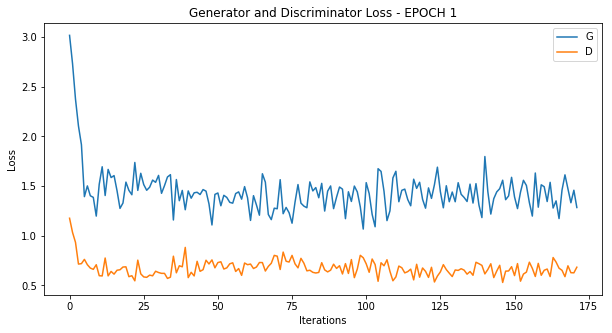

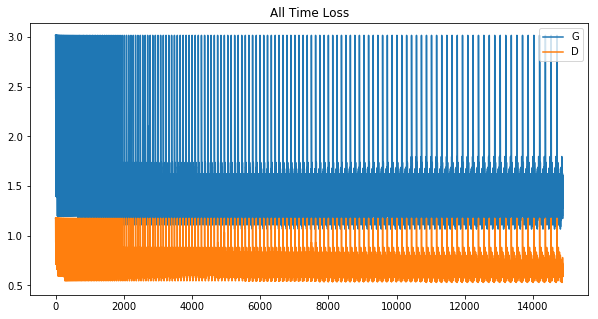

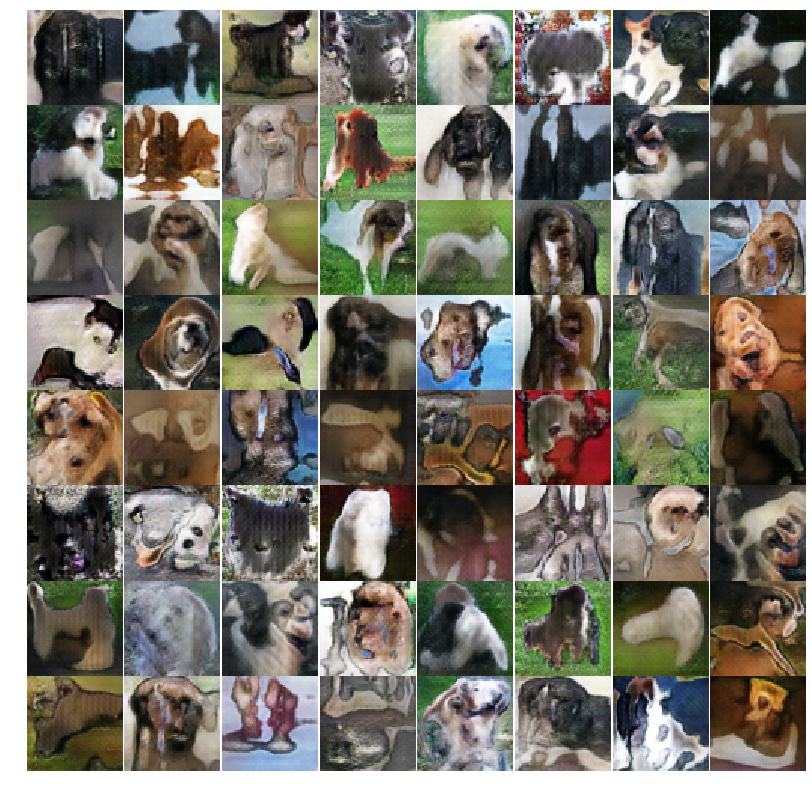

Epoch: 1 computed for 216.06151509284973 sec
Gen_loss mean:  1.4436631  std:  0.22905616


  0%|          | 1/300 [03:36<17:58:42, 216.46s/it]

Disc_loss mean:  0.67357606  std:  0.08261681


  1%|          | 2/300 [07:07<17:46:45, 214.78s/it]

Epoch: 2 computed for 210.65934872627258 sec
Gen_loss mean:  1.4427902  std:  0.18771748
Disc_loss mean:  0.63753325  std:  0.056406975


  1%|          | 3/300 [10:37<17:36:14, 213.38s/it]

Epoch: 3 computed for 209.93707036972046 sec
Gen_loss mean:  1.5123364  std:  0.55185544
Disc_loss mean:  0.7054432  std:  0.31039768


  1%|▏         | 4/300 [14:07<17:27:37, 212.36s/it]

Epoch: 4 computed for 209.76314854621887 sec
Gen_loss mean:  1.5664058  std:  0.69628054
Disc_loss mean:  0.7610706  std:  0.36949173


  2%|▏         | 5/300 [17:37<17:20:42, 211.67s/it]

Epoch: 5 computed for 209.86932253837585 sec
Gen_loss mean:  1.5368539  std:  0.66506225
Disc_loss mean:  0.7860093  std:  0.28073204


  2%|▏         | 6/300 [21:07<17:14:31, 211.13s/it]

Epoch: 6 computed for 209.6633849143982 sec
Gen_loss mean:  1.562661  std:  0.51041836
Disc_loss mean:  0.6792665  std:  0.1571295


  2%|▏         | 7/300 [24:36<17:08:48, 210.68s/it]

Epoch: 7 computed for 209.42724919319153 sec
Gen_loss mean:  1.5923581  std:  0.7091154
Disc_loss mean:  0.77964634  std:  0.27297103


  3%|▎         | 8/300 [28:07<17:04:59, 210.61s/it]

Epoch: 8 computed for 210.27774453163147 sec
Gen_loss mean:  1.5854663  std:  0.7298588
Disc_loss mean:  0.8041364  std:  0.35930872


  3%|▎         | 9/300 [31:37<17:01:04, 210.53s/it]

Epoch: 9 computed for 210.16020011901855 sec
Gen_loss mean:  1.5497962  std:  0.6947378
Disc_loss mean:  0.8437138  std:  0.47999862


  3%|▎         | 10/300 [35:07<16:56:12, 210.25s/it]

Epoch: 10 computed for 209.40751123428345 sec
Gen_loss mean:  1.5969554  std:  0.58356094
Disc_loss mean:  0.68088347  std:  0.18336448
Epoch: 11 computed for 209.86990523338318 sec
Gen_loss mean:  1.6548828  std:  0.91485345


  4%|▎         | 11/300 [38:37<16:52:27, 210.20s/it]

Disc_loss mean:  0.8535347  std:  0.4857906


  4%|▍         | 12/300 [42:06<16:47:35, 209.92s/it]

Epoch: 12 computed for 209.07930326461792 sec
Gen_loss mean:  1.5367359  std:  0.62426233
Disc_loss mean:  0.7767585  std:  0.26659244


  4%|▍         | 13/300 [45:35<16:42:14, 209.53s/it]

Epoch: 13 computed for 208.42381954193115 sec
Gen_loss mean:  1.608727  std:  0.6536448
Disc_loss mean:  0.72903794  std:  0.20702486


  5%|▍         | 14/300 [49:03<16:37:17, 209.22s/it]

Epoch: 14 computed for 208.31758785247803 sec
Gen_loss mean:  1.568338  std:  0.6510492
Disc_loss mean:  0.7882491  std:  0.39865103


  5%|▌         | 15/300 [52:32<16:32:45, 209.00s/it]

Epoch: 15 computed for 208.3010048866272 sec
Gen_loss mean:  1.6257488  std:  0.7788551
Disc_loss mean:  0.7857973  std:  0.40524063


  5%|▌         | 16/300 [56:00<16:28:26, 208.83s/it]

Epoch: 16 computed for 208.22274136543274 sec
Gen_loss mean:  1.5530914  std:  0.59850883
Disc_loss mean:  0.7358709  std:  0.2126357
Epoch: 17 computed for 208.2697024345398 sec
Gen_loss mean:  1.6073216  std:  0.77093303


  6%|▌         | 17/300 [59:29<16:24:28, 208.72s/it]

Disc_loss mean:  0.80138737  std:  0.3407293
Epoch: 18 computed for 208.45670652389526 sec
Gen_loss mean:  1.6022669  std:  0.58498764
Disc_loss mean: 

  6%|▌         | 18/300 [1:02:57<16:20:55, 208.71s/it]

 0.6912995  std:  0.208935


  6%|▋         | 19/300 [1:06:26<16:16:41, 208.54s/it]

Epoch: 19 computed for 207.98917436599731 sec
Gen_loss mean:  1.612637  std:  0.81491923
Disc_loss mean:  0.82500863  std:  0.5301062


  7%|▋         | 20/300 [1:09:54<16:13:03, 208.51s/it]

Epoch: 20 computed for 208.24378323554993 sec
Gen_loss mean:  1.5528611  std:  0.6437582
Disc_loss mean:  0.7780767  std:  0.3689529


  7%|▋         | 21/300 [1:13:23<16:09:55, 208.59s/it]

Epoch: 21 computed for 208.56099915504456 sec
Gen_loss mean:  1.6443336  std:  0.7497024
Disc_loss mean:  0.73166203  std:  0.23860095


  7%|▋         | 22/300 [1:16:51<16:06:33, 208.61s/it]

Epoch: 22 computed for 208.4746332168579 sec
Gen_loss mean:  1.6061652  std:  0.7255582
Disc_loss mean:  0.7792324  std:  0.2716504


  8%|▊         | 23/300 [1:20:20<16:03:26, 208.69s/it]

Epoch: 23 computed for 208.6713047027588 sec
Gen_loss mean:  1.5683019  std:  0.70330817
Disc_loss mean:  0.78045654  std:  0.30059513


  8%|▊         | 24/300 [1:23:48<15:59:15, 208.54s/it]

Epoch: 24 computed for 207.97905254364014 sec
Gen_loss mean:  1.5844284  std:  0.58923715
Disc_loss mean:  0.7074559  std:  0.2146791


  8%|▊         | 25/300 [1:27:17<15:55:54, 208.56s/it]

Epoch: 25 computed for 208.4389398097992 sec
Gen_loss mean:  1.5908854  std:  0.74730825
Disc_loss mean:  0.8306353  std:  0.4943813
Epoch: 26 computed for 208.7574498653412 sec
Gen_loss mean:  1.5324631  std:  0.7334623


  9%|▊         | 26/300 [1:30:46<15:52:59, 208.68s/it]

Disc_loss mean:  0.8741782  std:  0.5356802


  9%|▉         | 27/300 [1:34:15<15:49:46, 208.74s/it]

Epoch: 27 computed for 208.68822479248047 sec
Gen_loss mean:  1.5695703  std:  0.6318368
Disc_loss mean:  0.73831534  std:  0.27832276


  9%|▉         | 28/300 [1:37:44<15:46:55, 208.88s/it]

Epoch: 28 computed for 209.01801323890686 sec
Gen_loss mean:  1.6048672  std:  0.7743673
Disc_loss mean:  0.79082394  std:  0.54925907


 10%|▉         | 29/300 [1:41:13<15:43:09, 208.82s/it]

Epoch: 29 computed for 208.47088241577148 sec
Gen_loss mean:  1.5542305  std:  0.57179755
Disc_loss mean:  0.729541  std:  0.24187814


 10%|█         | 30/300 [1:44:41<15:39:14, 208.72s/it]

Epoch: 30 computed for 208.29870200157166 sec
Gen_loss mean:  1.5971978  std:  0.6987147
Disc_loss mean:  0.7515931  std:  0.24149393


 10%|█         | 31/300 [1:48:10<15:35:49, 208.73s/it]

Epoch: 31 computed for 208.57150840759277 sec
Gen_loss mean:  1.6014433  std:  0.67153406
Disc_loss mean:  0.7214485  std:  0.23717517


 11%|█         | 32/300 [1:51:38<15:31:33, 208.56s/it]

Epoch: 32 computed for 207.9560468196869 sec
Gen_loss mean:  1.5783869  std:  0.71228087
Disc_loss mean:  0.7947146  std:  0.42929626


 11%|█         | 33/300 [1:55:06<15:26:35, 208.22s/it]

Epoch: 33 computed for 207.28144574165344 sec
Gen_loss mean:  1.5425048  std:  0.61899257
Disc_loss mean:  0.7906182  std:  0.45800543


 11%|█▏        | 34/300 [1:58:34<15:23:54, 208.40s/it]

Epoch: 34 computed for 208.60711693763733 sec
Gen_loss mean:  1.5677592  std:  0.65261614
Disc_loss mean:  0.76133907  std:  0.34243858
Epoch: 35 computed for 208.43179774284363 sec
Gen_loss mean:  1.5922714  std:  0.73923236


 12%|█▏        | 35/300 [2:02:03<15:20:44, 208.47s/it]

Disc_loss mean:  0.8273067  std:  0.5201212


 12%|█▏        | 36/300 [2:05:31<15:16:14, 208.24s/it]

Epoch: 36 computed for 207.48172879219055 sec
Gen_loss mean:  1.5666199  std:  0.61255264
Disc_loss mean:  0.7306946  std:  0.30583268


 12%|█▏        | 37/300 [2:08:59<15:12:50, 208.25s/it]

Epoch: 37 computed for 208.1044352054596 sec
Gen_loss mean:  1.5947912  std:  0.63680506
Disc_loss mean:  0.72893  std:  0.2672595


 13%|█▎        | 38/300 [2:12:27<15:08:43, 208.11s/it]

Epoch: 38 computed for 207.59558749198914 sec
Gen_loss mean:  1.5770428  std:  0.6484942
Disc_loss mean:  0.77414614  std:  0.37534347


 13%|█▎        | 39/300 [2:15:56<15:06:12, 208.32s/it]

Epoch: 39 computed for 208.659526348114 sec
Gen_loss mean:  1.5985707  std:  0.5538135
Disc_loss mean:  0.66790456  std:  0.14386047


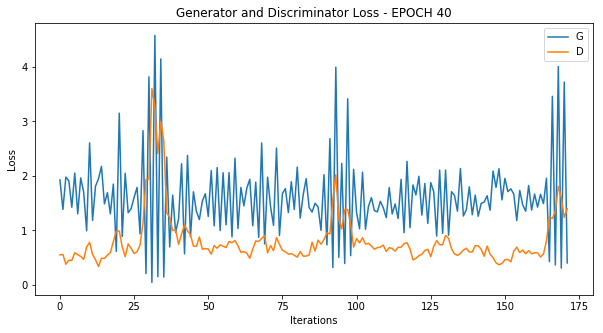

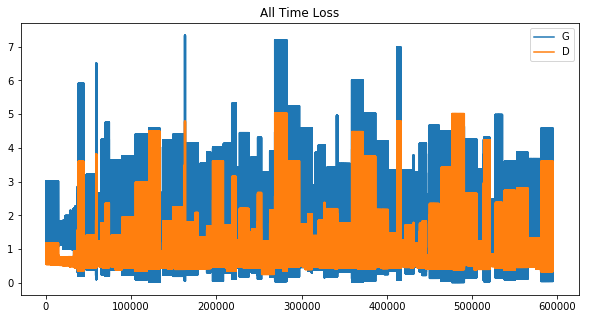

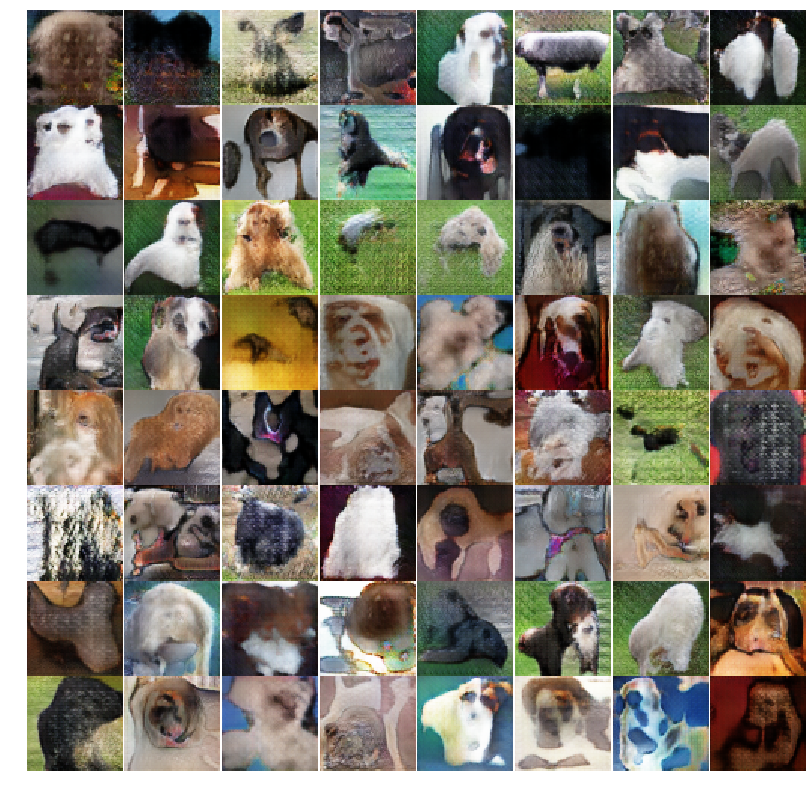

Epoch: 40 computed for 215.5353283882141 sec


 13%|█▎        | 40/300 [2:19:32<15:12:35, 210.60s/it]

Gen_loss mean:  1.6051203  std:  0.75059366
Disc_loss mean:  0.81383836  std:  0.4815303
Epoch: 41 computed for 208.69989609718323 sec
Gen_loss mean:  1.599204  std:  0.6142688


 14%|█▎        | 41/300 [2:23:00<15:06:53, 210.09s/it]

Disc_loss mean:  0.6999417  std:  0.23455411


 14%|█▍        | 42/300 [2:26:29<15:01:33, 209.67s/it]

Epoch: 42 computed for 208.4995768070221 sec
Gen_loss mean:  1.5901867  std:  0.7686611
Disc_loss mean:  0.84721696  std:  0.46667978


 14%|█▍        | 43/300 [2:29:58<14:56:35, 209.32s/it]

Epoch: 43 computed for 208.34237098693848 sec
Gen_loss mean:  1.589903  std:  0.5528525
Disc_loss mean:  0.6753999  std:  0.22322704


 15%|█▍        | 44/300 [2:33:26<14:51:30, 208.95s/it]

Epoch: 44 computed for 207.87347960472107 sec
Gen_loss mean:  1.5984802  std:  0.68419904
Disc_loss mean:  0.75649244  std:  0.43911952


 15%|█▌        | 45/300 [2:36:54<14:47:36, 208.85s/it]

Epoch: 45 computed for 208.43784880638123 sec
Gen_loss mean:  1.4326295  std:  0.77139944
Disc_loss mean:  1.0377841  std:  0.8508982


 15%|█▌        | 46/300 [2:40:23<14:44:02, 208.83s/it]

Epoch: 46 computed for 208.59646201133728 sec
Gen_loss mean:  1.478954  std:  0.5028524
Disc_loss mean:  0.7598899  std:  0.21795513


 16%|█▌        | 47/300 [2:43:52<14:40:11, 208.74s/it]

Epoch: 47 computed for 208.36257982254028 sec
Gen_loss mean:  1.569381  std:  0.72759795
Disc_loss mean:  0.8151641  std:  0.40429977


 16%|█▌        | 48/300 [2:47:21<14:36:51, 208.78s/it]

Epoch: 48 computed for 208.6846981048584 sec
Gen_loss mean:  1.5759547  std:  0.5247448
Disc_loss mean:  0.6643794  std:  0.12065858


 16%|█▋        | 49/300 [2:50:49<14:33:06, 208.71s/it]

Epoch: 49 computed for 208.36261630058289 sec
Gen_loss mean:  1.5328408  std:  0.71419865
Disc_loss mean:  0.85869867  std:  0.48815036


W0829 11:31:51.050043 140419294877568 deprecation.py:323] From <ipython-input-50-5ec5f6d4f784>:30: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


Saved temporary images for evaluation.
FID: 100.15833
distance: 1.00000
MiFID: 100.15833
Removed temporary image directory.
Found model improvement.., Checkpointing..
Epoch: 50 computed for 885.7811465263367 sec
Gen_loss mean:  1.5299442  std:  0.67613834


 17%|█▋        | 50/300 [3:05:35<28:36:14, 411.90s/it]

Disc_loss mean:  0.8651682  std:  0.64271945


 17%|█▋        | 51/300 [3:09:05<24:17:42, 351.25s/it]

Epoch: 51 computed for 209.58498811721802 sec
Gen_loss mean:  1.5156878  std:  0.5549599
Disc_loss mean:  0.7704888  std:  0.34828198


 17%|█▋        | 52/300 [3:12:34<21:15:30, 308.59s/it]

Epoch: 52 computed for 208.85962200164795 sec
Gen_loss mean:  1.5442476  std:  0.56261396
Disc_loss mean:  0.73548895  std:  0.3161692
Epoch: 53 computed for 208.4191529750824 sec
Gen_loss mean:  1.3796933  std:  0.6518952


 18%|█▊        | 53/300 [3:16:03<19:06:57, 278.62s/it]

Disc_loss mean:  1.0081557  std:  0.6849793


 18%|█▊        | 54/300 [3:19:32<17:36:55, 257.79s/it]

Epoch: 54 computed for 208.99990010261536 sec
Gen_loss mean:  1.538114  std:  0.58475727
Disc_loss mean:  0.74161595  std:  0.23980637


 18%|█▊        | 55/300 [3:23:01<16:33:14, 243.24s/it]

Epoch: 55 computed for 209.1435604095459 sec
Gen_loss mean:  1.5819982  std:  0.536449
Disc_loss mean:  0.67299265  std:  0.1473124


 19%|█▊        | 56/300 [3:26:30<15:47:21, 232.96s/it]

Epoch: 56 computed for 208.77040839195251 sec
Gen_loss mean:  1.5106953  std:  0.69524246
Disc_loss mean:  0.855603  std:  0.51212996


 19%|█▉        | 57/300 [3:29:59<15:14:17, 225.75s/it]

Epoch: 57 computed for 208.76696968078613 sec
Gen_loss mean:  1.5478288  std:  0.6152892
Disc_loss mean:  0.7639945  std:  0.34208843


 19%|█▉        | 58/300 [3:33:28<14:50:41, 220.83s/it]

Epoch: 58 computed for 209.1590132713318 sec
Gen_loss mean:  1.5783488  std:  0.68807584
Disc_loss mean:  0.7867693  std:  0.4757166
Epoch: 59 computed for 208.58759474754333 sec
Gen_loss mean:  1.5423744  std:  0.5965058


 20%|█▉        | 59/300 [3:36:57<14:32:30, 217.22s/it]

Disc_loss mean:  0.76188606  std:  0.46175694


 20%|██        | 60/300 [3:40:26<14:19:02, 214.76s/it]

Epoch: 60 computed for 208.8179795742035 sec
Gen_loss mean:  1.5554795  std:  0.5941346
Disc_loss mean:  0.7470217  std:  0.3688093


 20%|██        | 61/300 [3:43:55<14:08:43, 213.07s/it]

Epoch: 61 computed for 208.92906212806702 sec
Gen_loss mean:  1.5383029  std:  0.64511687
Disc_loss mean:  0.7998492  std:  0.48795316
Epoch: 62 computed for 208.9891426563263 sec
Gen_loss mean:  1.5538472  std:  0.53102785
Disc_loss mean:  0.6911441  std:  0.17076744


 21%|██        | 63/300 [3:50:53<13:53:31, 211.02s/it]

Epoch: 63 computed for 208.75045585632324 sec
Gen_loss mean:  1.5512965  std:  0.71699464
Disc_loss mean:  0.8433767  std:  0.61445063
Epoch: 64 computed for 209.4620053768158 sec
Gen_loss mean:  1.5196743  std:  0.46155316
Disc_loss mean:  

 21%|██▏       | 64/300 [3:54:23<13:48:25, 210.62s/it]

0.68368936  std:  0.13258573


 22%|██▏       | 65/300 [3:57:52<13:43:12, 210.18s/it]

Epoch: 65 computed for 208.969562292099 sec
Gen_loss mean:  1.5553865  std:  0.74259883
Disc_loss mean:  0.86397094  std:  0.50950783


 22%|██▏       | 66/300 [4:01:21<13:38:16, 209.81s/it]

Epoch: 66 computed for 208.7557499408722 sec
Gen_loss mean:  1.5642091  std:  0.48034686
Disc_loss mean:  0.6530615  std:  0.11992973
Epoch: 67 computed for 209.02206826210022 sec
Gen_loss mean:  1.5418254  std:  0.65161526


 22%|██▏       | 67/300 [4:04:50<13:34:05, 209.64s/it]

Disc_loss mean:  0.80537754  std:  0.40934578


 23%|██▎       | 68/300 [4:08:20<13:30:21, 209.57s/it]

Epoch: 68 computed for 209.2302656173706 sec
Gen_loss mean:  1.5418988  std:  0.65358657
Disc_loss mean:  0.78895515  std:  0.40367332


In [0]:
#%%time
train(dog_features_data, EPOCHS)

&nbsp;&nbsp;&nbsp;As we can observe, the MIFID steadily improves for 260 epochs (~ 8 hours). The best score that I achieved using this model during the competition was <b>55.87</b> (on the public dataset). The learning process does tend to be somewhat random so I think a score around the region of <b>[50, 65]</b> should be realistic.

### Generate a test image

&nbsp;&nbsp;&nbsp;We can also reuse one of the previous functions to generate a single random dog image.

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
generate_test_image(dog_generator)

### Generate 10000 images for submission and save them to a zip file

In [0]:
#zip_images()

### Create an animated GIF using the training images

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return Image.open('./training_checkpoints/image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 1*(i**2)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    IPython.display.Image(filename=anim_file)

## Conclusion

&nbsp;&nbsp;&nbsp;To sum up, <b>DCGANs</b> seem to be extremely sensitive to hyperparameter choice and a lot of problems can arise during training, including <b>Mode Collapse</b>. They are also very computationally intensive and it is incredibly hard to build a high-scoring model for a runtime of <b>~9 hours</b>. Fortunately, there is a whole bucket list of possible methods and techniques that are well-documented and can be easily applied to your model to stabilize the training process.

&nbsp;&nbsp;&nbsp;For me personally, it was really fun to toy around with these techniques and break a few kernels in the process :D. Feel free to leave any suggestions down in the comments (for improving the model or fixing something that I messed up).

&nbsp;&nbsp;&nbsp;If this kernel helped you in any way, feel free to leave an upvote. Also big thanks to <b>Chris Deotte, Nanashi, Chad Malla and Nirjhar Roy</b> for their kernels. I'll leave links to them down below.

## References

### Useful Kernels and notebooks

[1]. My previous kernel on [EDA and image preprocessing](https://www.kaggle.com/jadeblue/dog-generator-starter-eda-preprocessing)

[2]. [Xml parsing and cropping to specified bounding box](https://www.kaggle.com/paulorzp/show-annotations-and-breeds)

[3]. [Image cropping method with interpolation](https://www.kaggle.com/amanooo/wgan-gp-keras)

[4]. [Another great Keras-based DCGAN approach by Chad Malla](https://www.kaggle.com/cmalla94/dcgan-generating-dog-images-with-tensorflow)

[5]. [DCGAN hacks for improving your model performance](https://www.kaggle.com/c/generative-dog-images/discussion/98595)

[6]. [Tensorflow DCGAN tutorial](https://www.tensorflow.org/beta/tutorials/generative/dcgan)

[7]. [DCGAN Dogs Images by Nanashi](https://www.kaggle.com/jesucristo/introducing-dcgan-dogs-images)

[8]. [GAN dogs starter 24-Jul -Custom Layers by Nirjhar Roy](https://www.kaggle.com/phoenix9032/gan-dogs-starter-24-jul-custom-layers)

[9]. [Supervised Generative Dog Net by Chris Deotte](https://www.kaggle.com/cdeotte/supervised-generative-dog-net)

[10]. [My best submission for this competition](https://www.kaggle.com/jadeblue/dogdcgan-v6-ksize)

### Research papers, posts and discussions

[1]. [Generative Adversarial Networks official paper](https://arxiv.org/pdf/1406.2661.pdf)

[2]. [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

[3]. [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

[4]. [DCGAN official paper](https://arxiv.org/pdf/1511.06434.pdf)

[5]. [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)

[6]. [Weight Initialization Techniques in Neural Networks](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)

[7]. [Spectral Normalization for Generative Adversarial Networks paper](https://arxiv.org/pdf/1802.05957.pdf)

[8]. [Spectral Normalization implemented in Keras](https://github.com/IShengFang/SpectralNormalizationKeras)

[9]. [Spectral Normalization Explained](https://christiancosgrove.com/blog/2018/01/04/spectral-normalization-explained.html)

[10]. [GAN — Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)

[11]. [How to Implement GAN Hacks in Keras to Train Stable Models](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/)

[12]. [Tricks of GANS](https://lanpartis.github.io/deep%20learning/2018/03/12/tricks-of-gans.html)

[13]. [Instance Noise: A trick for stabilising GAN training](https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/)

[14]. [GAN — RSGAN & RaGAN (A new generation of cost function.)](https://medium.com/@jonathan_hui/gan-rsgan-ragan-a-new-generation-of-cost-function-84c5374d3c6e)

[15]. [A simple explanation of the Inception Score](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a)

[16]. [GAN — How to measure GAN performance?](https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732)

[17]. [All you need is GAN Hacks](https://www.kaggle.com/c/generative-dog-images/discussion/98595#latest-582912)

[18]. [How to train your touchy GANs - Things that seem to work.](https://www.kaggle.com/c/generative-dog-images/discussion/102155#latest-599429)

[19]. [Explaining the metric FID](https://www.kaggle.com/c/generative-dog-images/discussion/97809#latest-591866)